<a href="https://colab.research.google.com/github/Prithviraj8/DL_Labs/blob/master/dl_hw2_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 2 - Convolutional Neural Nets

In this homework, we will be working with google [colab](https://colab.research.google.com/). Google colab allows you to run a jupyter notebook on google servers using a GPU or TPU. To enable GPU support, make sure to press Runtime -> Change Runtime Type -> GPU.

In [ ]:
### Installing CUDA
# !wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
# !sudo mv cuda-ubuntu2004.pin /etc/apt/preferences.d/cuda-repository-pin-600
# !wget https://developer.download.nvidia.com/compute/cuda/12.3.2/local_installers/cuda-repo-ubuntu2004-12-3-local_12.3.2-545.23.08-1_amd64.deb
# !sudo dpkg -i cuda-repo-ubuntu2004-12-3-local_12.3.2-545.23.08-1_amd64.deb
# !sudo cp /var/cuda-repo-ubuntu2004-12-3-local/cuda-*-keyring.gpg /usr/share/keyrings/
# !sudo apt-get update
# !sudo apt-get -y install cuda-toolkit-12-3

# !apt-get -y install cuda-11-7


--2024-02-18 16:11:20--  https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64/cuda-ubuntu2004.pin
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190 [application/octet-stream]
Saving to: ‘cuda-ubuntu2004.pin’

cuda-ubuntu2004.pin 100%[===================>]     190  --.-KB/s    in 0s      

2024-02-18 16:11:20 (4.94 MB/s) - ‘cuda-ubuntu2004.pin’ saved [190/190]

--2024-02-18 16:11:20--  https://developer.download.nvidia.com/compute/cuda/12.3.2/local_installers/cuda-repo-ubuntu2004-12-3-local_12.3.2-545.23.08-1_amd64.deb
Resolving developer.download.nvidia.com (developer.download.nvidia.com)... 152.195.19.142
Connecting to developer.download.nvidia.com (developer.download.nvidia.com)|152.195.19.142|:443... connected.
HTTP request sent, awaiting response... 200 O

## Cats vs dogs classification

To learn about and experiment with convolutional neural nets we will be working on a problem of great importance in computer vision - classifying images of cats and dogs.

The problem is so important that there's even an easter egg in colab: go to Tools -> Settings -> Miscellaneous and enable 'Corgi mode' and 'Kitty mode' to get more cats and dogs to classify when you're tired of coding.



### Getting the data

To get started with the classification, we first need to download and unpack the dataset (note that in jupyter notebooks commands starting with `!` are executed in bash, not in python):

In [2]:
! wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2024-02-20 00:48:22--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.128.207, 74.125.143.207, 173.194.69.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.128.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M  30.2MB/s    in 2.2s    

2024-02-20 00:48:24 (30.2 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
! unzip -qo cats_and_dogs_filtered.zip

This dataset contains two directories, `train` and `validation`. Both in turn contain two directories with images: `cats` and `dogs`. In `train` we have 1000 images of cats, and another 1000 images of dogs. For `validation`, we have 500 images of each class. Our goal is to implement and train a convolutional neural net to classify these images, i.e. given an image from this dataset, tell if it contains a cat or a dog.



In [4]:
! echo 'Training cats examples:' $(find cats_and_dogs_filtered/train/cats -type f | wc -l)
! echo 'Training dogs examples:' $(find cats_and_dogs_filtered/train/dogs -type f | wc -l)
! echo 'Validation cats examples:' $(find cats_and_dogs_filtered/validation/cats -type f | wc -l)
! echo 'Validation dogs examples:' $(find cats_and_dogs_filtered/validation/dogs -type f | wc -l)

Training cats examples: 1000
Training dogs examples: 1000
Validation cats examples: 500
Validation dogs examples: 500


### Loading the data
 Now that we have the data on our disk, we need to load it so that we can use it to train our model. In Pytorch ecosystem, we use `Dataset` class, documentation for which can be found [here](https://pytorch.org/docs/stable/data.html).

 In the case of computer vision, the datasets with the folder structure 'label_name/image_file' are very common, and to process those there's already a class `torchvision.datasets.ImageFolder` (documented [here](https://pytorch.org/vision/0.8/datasets.html)). Torchvision is a Pytorch library with many commonly used tools in computer vision.

 Another thing we need from Torchvision library is transforms ([documentation](https://pytorch.org/docs/stable/torchvision/transforms.html)). In computer vision, we very often want to transform the images in certain ways. The most common is normalization. Others include flipping, changing saturation, hue, contrast, rotation, and blurring.

 Below, we create a training, validation and test sets. We use a few transforms for augmentation on the training set, but we don't use anything but resize and normalization for validation and test.

In [5]:
import torch
import torchvision
from torchvision import transforms
from PIL import Image # PIL is a library to process images

# These numbers are mean and std values for channels of natural images.
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Inverse transformation: needed for plotting.
unnormalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

train_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ColorJitter(hue=.1, saturation=.1, contrast=.1),
                                    transforms.RandomRotation(20, interpolation=transforms.InterpolationMode.BILINEAR),
                                    transforms.GaussianBlur(7, sigma=(0.1, 1.0)),
                                    transforms.ToTensor(),  # convert PIL to Pytorch Tensor
                                    normalize,
                                ])

validation_transforms = transforms.Compose([
                                    transforms.Resize((256, 256)),
                                    transforms.ToTensor(),
                                    normalize,
                                ])

train_dataset = torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/train', transform=train_transforms)
validation_dataset, test_dataset = torch.utils.data.random_split(torchvision.datasets.ImageFolder('./cats_and_dogs_filtered/validation', transform=validation_transforms), [500, 500], generator=torch.Generator().manual_seed(42))

Let's see what one of the images in the dataset looks like (you can run this cell multiple times to see the effects of different augmentations):

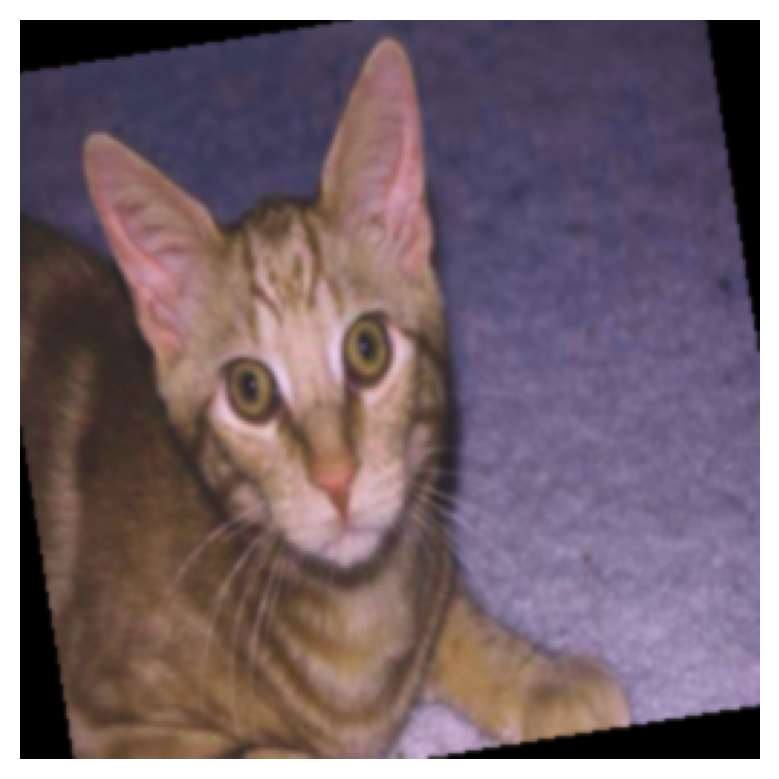

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 200 # change dpi to make plots bigger

def show_normalized_image(img, title=None):
  plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))
  plt.title(title)
  plt.axis('off')

show_normalized_image(train_dataset[10][0])

### Creating the model

Now is the time to create a model. All models in Pytorch are subclassing `torch.nn.Module`, and have to implement `__init__` and `forward` methods.

Below we provide a simple model skeleton, which you need to expand. The places to put your code are marked with `TODO`. Here, we ask you to implement a convolutional neural network containing the following elements:

* Convolutional layers (at least two)
* Batch Norm
* Non-linearity
* Pooling layers
* A residual connection similar to that of Res-Net
* A fully connected layer

For some examples of how to implement Pytorch models, please refer to our lab notebooks, such as [this one](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb).

In [7]:
# # Reset CUDA memory
# from numba import cuda
# device = cuda.get_current_device()
# device.reset()

# !nvcc-version
import torch
print(torch.cuda.is_available())

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # If CUDA is available, use the GPU (assuming a single GPU, index 0)
    print("Connected to Cuda")
else:
    device = torch.device("cpu")  # If CUDA is not available, fall back to the CPU
    print("Connected to cpu")


In [11]:
from torch import nn
# Adjust max_split_size_mb
# torch.cuda.set_per_process_memory_fraction(0.5, 0)
# torch.cuda.empty_cache()

class CNN_Solution(torch.nn.Module):
  def __init__(self):
    super(CNN_Solution, self).__init__()

    self.conv_layer_1 = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=64),
      nn.MaxPool2d(kernel_size=2))

    self.conv_layer_2 = nn.Sequential(
      nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=256),
      nn.MaxPool2d(kernel_size=2))

    self.conv_layer_3 = nn.Sequential(

      nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.BatchNorm2d(num_features=256),
      nn.MaxPool2d(kernel_size=2))

    self.adjust_res = nn.Sequential(
    nn.Conv2d(64, 256, kernel_size=1, stride=2, padding=0),  # Adjust as necessary
    nn.BatchNorm2d(256)
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=256*4*4, out_features=1),
      nn.Sigmoid())

  def forward(self, x):
    x = self.conv_layer_1(x)
    x = self.conv_layer_2(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.conv_layer_3(x)
    x = self.classifier(x)
    return x

# With res-net
  # def forward(self, x):
  #   x = self.conv_layer_1(x)
  #   x = self.conv_layer_2(x)

  #   residual = self.adjust_res(x)  # Adjust the residual to match x after conv_layer_3
  #   for _ in range(3):  # Apply conv_layer_3 multiple times with residual connection
  #       x = self.conv_layer_3(x)
  #   x += residual  # Add the adjusted residual connection

  #   x = self.classifier(x)
  #   return x

### Training the model

*Now we train the model on the dataset. Again, we're providing you with the skeleton with some parts marked as `TODO` to be filled by you.*

In [13]:

from tqdm.notebook import tqdm

# For debugging
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
def get_loss_and_correct(model, batch, criterion, device, return_correct_indices=False):
  # Implement forward pass and loss calculation for one batch.
  # Remember to move the batch to device.
  #
  # Return a tuple:
  # - loss for the batch (Tensor)
  # - number of correctly classified examples in the batch (Tensor)
  data, target = batch
  data, target = data.float().to(device), target.float().to(device)

  pred = model(data).squeeze()
  loss = criterion(pred, target)
  # print(data, pred, loss)

  # pred_class = torch.argmax(torch.softmax(pred, dim=1), dim=1)
  # correct = (pred_class == target).sum().item()/len(pred)
  correct = pred.round() ==  target
  correct_indices = correct.nonzero().squeeze()
  correct = (correct).sum(dim=0)

  if return_correct_indices:
    return loss, correct, correct_indices
  return loss, correct


def step(loss, optimizer, diagnose=False):
  # Implement backward pass and update.
  optimizer.zero_grad()
  loss.backward()
  weights, gradients = [], []
  for param, paramTensor in model.named_parameters():
    weights.append(paramTensor)
    gradients.append(paramTensor.grad)

  optimizer.step()

  if diagnose:
    return weights, gradients


N_EPOCHS = 50
BATCH_SIZE = 64
num_workers = 4

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=num_workers)
model = CNN_Solution()

# Info - With BCEWithLogitsLoss - Training Acc - 65.4%
# criterion = nn.BCEWithLogitsLoss()  # This loss function combines a Sigmoid layer and the BCELoss in one single class.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Using Adam optimizer with a learning rate of 0.001

# With BCELoss -
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # Using Adam optimizer with a learning rate of ____


model.train()
print('Using Cuda: ', torch.cuda.is_available())
if torch.cuda.is_available():

  # model = model.cuda()
  # criterion = criterion.cuda()
  model = model.to(device)
  criterion = criterion.to(device)

  device = torch.device("cuda:0")
else:
  device = torch.device("cpu")


train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

pbar = tqdm(range(N_EPOCHS))

for i in pbar:
  total_train_loss = 0.0
  total_train_correct = 0.0
  total_validation_loss = 0.0
  total_validation_correct = 0.0

  model.train()

  for batch in tqdm(train_dataloader, leave=False):
    loss, correct = get_loss_and_correct(model, batch, criterion, device)
    step(loss, optimizer)
    total_train_loss += loss.item()
    total_train_correct += correct.item()

  with torch.no_grad():
    for batch in validation_dataloader:
      loss, correct = get_loss_and_correct(model, batch, criterion, device)
      total_validation_loss += loss.item()
      total_validation_correct += correct.item()

  mean_train_loss = total_train_loss / len(train_dataset)
  train_accuracy = total_train_correct / len(train_dataset)

  mean_validation_loss = total_validation_loss / len(validation_dataset)
  validation_accuracy = total_validation_correct / len(validation_dataset)

  train_losses.append(mean_train_loss)
  validation_losses.append(mean_validation_loss)

  train_accuracies.append(train_accuracy)
  validation_accuracies.append(validation_accuracy)

  pbar.set_postfix({'train_loss': mean_train_loss, 'validation_loss': mean_validation_loss, 'train_accuracy': train_accuracy, 'validation_accuracy': validation_accuracy})

Using Cuda:  True


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

KeyboardInterrupt: 

Now that the model is trained, we want to visualize the training and validation losses and accuracies:

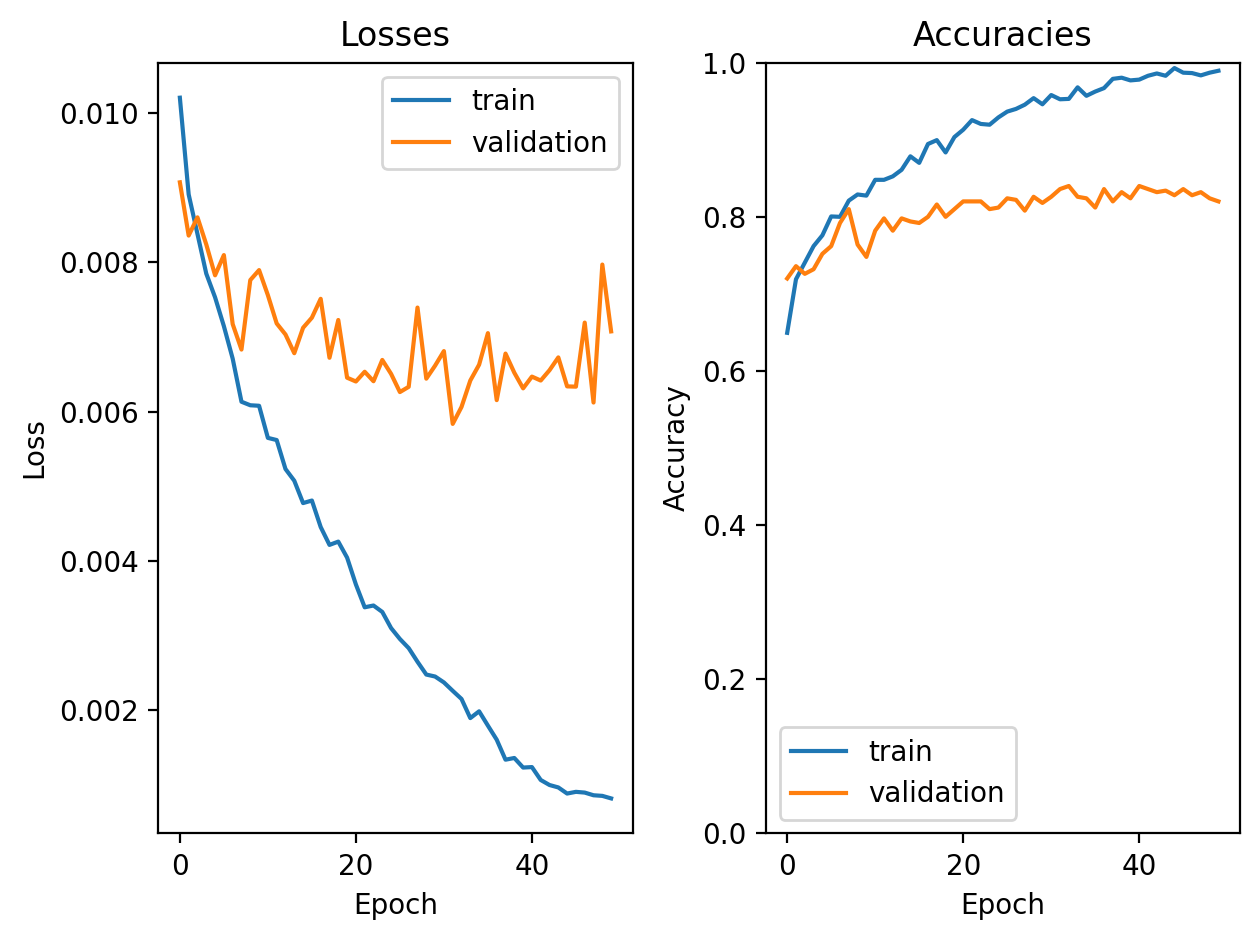

In [10]:
plt.figure(dpi=200)

plt.subplot(121)
plt.plot(train_losses, label='train')
plt.plot(validation_losses, label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Losses')
plt.legend()

plt.subplot(122)
plt.plot(train_accuracies, label='train')
plt.plot(validation_accuracies, label='validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Accuracies')

plt.tight_layout()

Now, change your model to achieve at least 75% accuracy on validation set. You can change the model you've implemented, the optimizer, and the augmentations.

Looking at the loss and accuracy plots, can you see if your model overfits the trainig set? Why?

Answer:
Yes, there is a difference between training and validation accuracy which means the model is overfitting the training set. The reasons could be:
1. Complex Model Architecture: Our model might have too many parameters relative to the amount of training data, enabling it to memorize the training data rather than learning to generalize.
2. Insufficient Training Data: A small dataset can lead to overfitting because the model doesn't see enough variations of the data to learn to generalize well.

### Testing the model

Now, use the `test_dataset` to get the final accuracy of your model. Visualize some correctly and incorrectly classified examples.

In [11]:
# TODO
# 1. Calculate and show the test_dataset accuracy of your model.
# 2. Visualize some correctly and incorrectly classified examples.

In [12]:
BATCH_SIZE = 64
input_size = (256, 256)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2)
model.eval()

total_test_loss = 0
total_test_correct = 0

correct_pred_indices = []
incorrect_pred_indices = []

with torch.no_grad():
  for batch in test_dataloader:
    loss, correct, correct_indices = get_loss_and_correct(model, batch, criterion, device, return_correct_indices=True)

    # get indices of incorrect indices
    all_indices = torch.arange(BATCH_SIZE).to(device)
    union = torch.cat((correct_indices, all_indices))
    uniques, counts = union.unique(return_counts=True)
    incorrect_indices = uniques[counts == 1]

    correct_pred_indices.append(correct_indices)
    incorrect_pred_indices.append(incorrect_indices)

    total_test_loss += loss.item()
    total_test_correct += correct.item()

mean_test_loss = total_test_loss / len(test_dataset)
test_accuracy = total_test_correct / len(test_dataset)

print(f"Test loss = {mean_test_loss}, Test accuracy: {test_accuracy * 100}%")

Test loss = 0.00846308845281601, Test accuracy: 78.2%


In [13]:
def get_dataset_idx(pred_indices):
  rand_idx = torch.randint(len(pred_indices), (1,)).item()
  idx_in_batch = pred_indices[i][rand_idx].item()
  return idx_in_batch


Here are some correctly and incorrectly classified images from the first three test batches:
(correct in first row, incorrect in second)



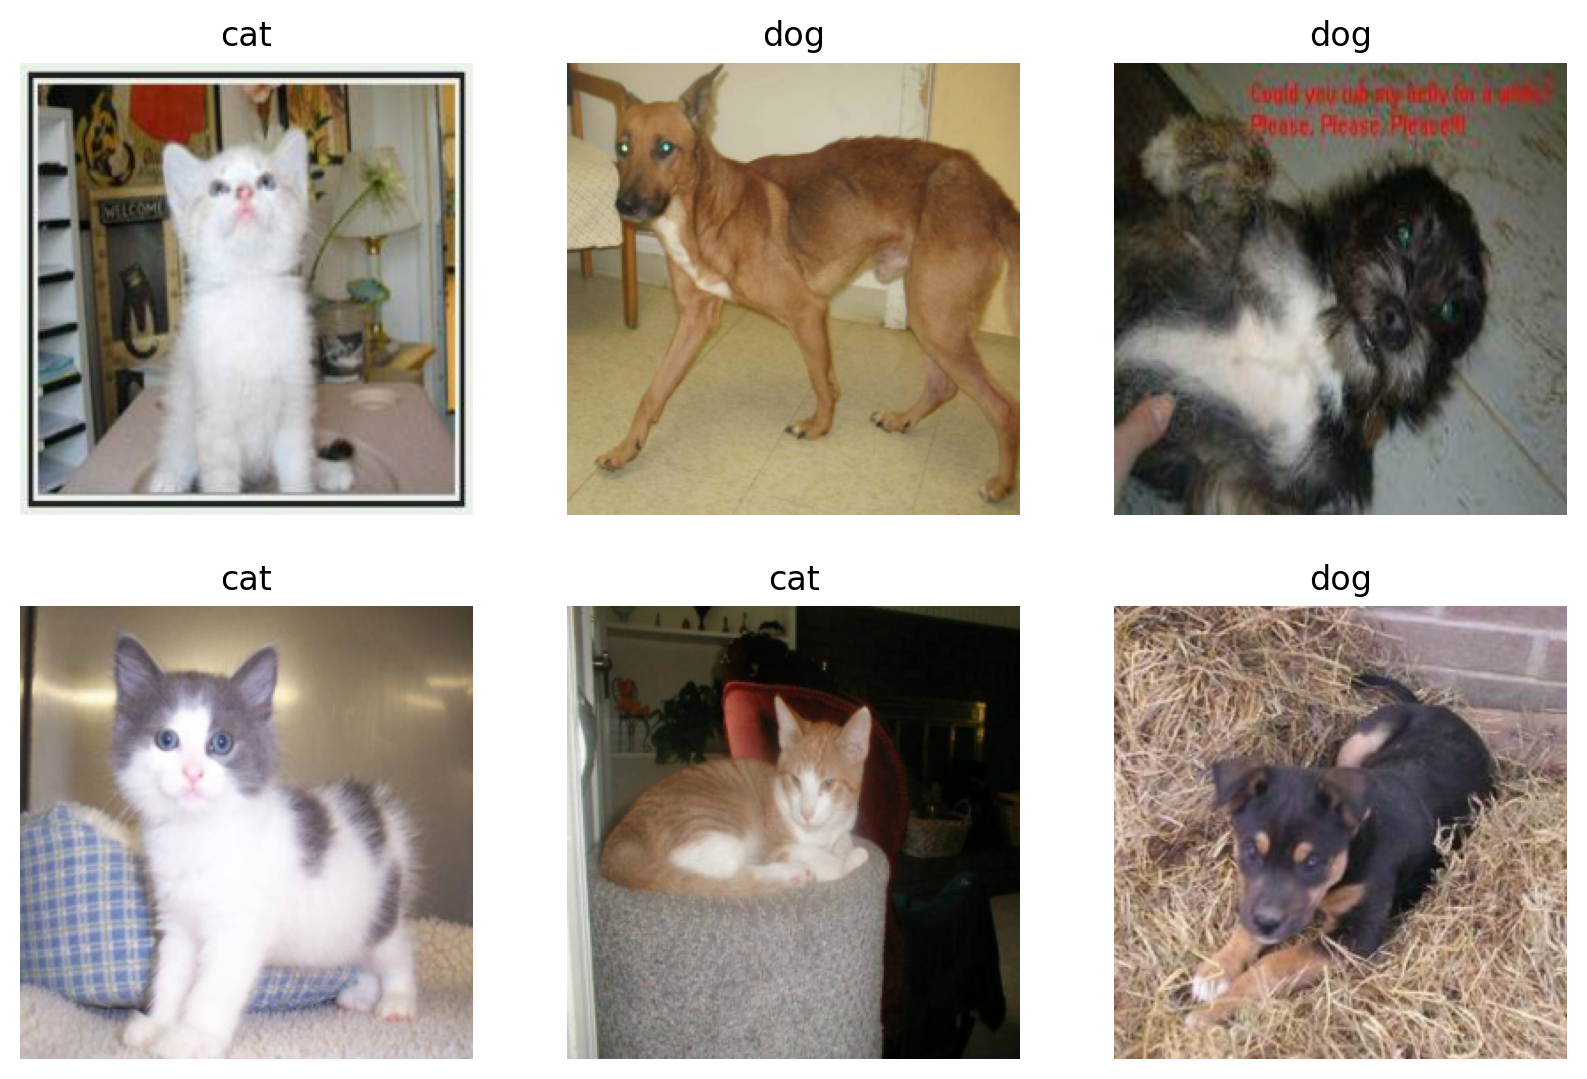

In [14]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
labels_map = {
    0: "cat",
    1: "dog"
}

print("\nHere are some correctly and incorrectly classified images from the first three test batches:")
print("(correct in first row, incorrect in second)\n")

for i in range(1, cols + 1):
    img, label = test_dataset[get_dataset_idx(correct_pred_indices)]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))

    img, label = test_dataset[get_dataset_idx(incorrect_pred_indices)]
    figure.add_subplot(rows, cols, rows + i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0))

plt.show()

## Let's save the model weights to pick intermediate representations from our network

```
# This is formatted as code
```



In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
torch.save(model.state_dict(), "/content/drive/My Drive/hw2_cnn_model_weights.pkl")

In [17]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
conv_layer_1.0.weight 	 torch.Size([64, 3, 3, 3])
conv_layer_1.0.bias 	 torch.Size([64])
conv_layer_1.2.weight 	 torch.Size([64])
conv_layer_1.2.bias 	 torch.Size([64])
conv_layer_1.2.running_mean 	 torch.Size([64])
conv_layer_1.2.running_var 	 torch.Size([64])
conv_layer_1.2.num_batches_tracked 	 torch.Size([])
conv_layer_2.0.weight 	 torch.Size([256, 64, 3, 3])
conv_layer_2.0.bias 	 torch.Size([256])
conv_layer_2.2.weight 	 torch.Size([256])
conv_layer_2.2.bias 	 torch.Size([256])
conv_layer_2.2.running_mean 	 torch.Size([256])
conv_layer_2.2.running_var 	 torch.Size([256])
conv_layer_2.2.num_batches_tracked 	 torch.Size([])
conv_layer_3.0.weight 	 torch.Size([256, 256, 3, 3])
conv_layer_3.0.bias 	 torch.Size([256])
conv_layer_3.2.weight 	 torch.Size([256])
conv_layer_3.2.bias 	 torch.Size([256])
conv_layer_3.2.running_mean 	 torch.Size([256])
conv_layer_3.2.running_var 	 torch.Size([256])
conv_layer_3.2.num_batches_tracked 	 torch.Size([])
classifier.1.weight 	 t

### Visualizing filters

In this part, we are going to visualize the output of one of the convolutional layers to see what features they focus on.

First, let's get some image.

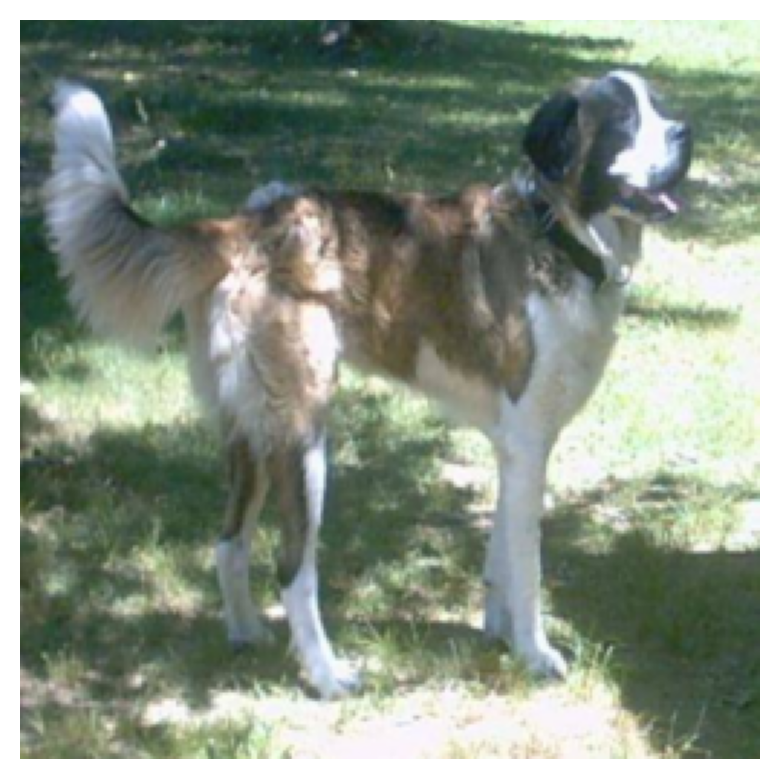

In [22]:
image = validation_dataset[10][0]
show_normalized_image(image)

Now, we are going to 'clip' our model at different points to get different intermediate representation.
Clip your model at two or three different points and plot the filters output.

In order to clip the model, you can use `model.children()` method. For example, to get output only after the first 4 layers, you can do:

```
clipped = nn.Sequential(
    *list(model.children()[:4])
)
intermediate_output = clipped(input)
```



In [30]:
import math

def plot_intermediate_output(result, title):
  """ Plots the intermediate output of shape
      N_FILTERS x H x W
  """
  n_filters = result.shape[1]
  N = int(math.sqrt(n_filters))
  M = (n_filters + N - 1) // N
  assert N * M >= n_filters

  fig, axs = plt.subplots(N, M)
  fig.suptitle(title)

  for i in range(N):
    for j in range(M):
      if i*N + j < n_filters:
        axs[i][j].imshow(result[0, i*N + j].cpu().detach())
        axs[i][j].axis('off')

# TODO:
# pick a few intermediate representations from your network and plot them using
# the provided function.
model = CNN_Solution()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_weights = torch.load("/content/drive/My Drive/hw2_cnn_model_weights.pkl", map_location=device)
model.load_state_dict(model_weights)
model.eval()
model.to(device)

CNN_Solution(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in

In [31]:
print("Model Layers")
print("============")
print(model)

Model Layers
CNN_Solution(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (

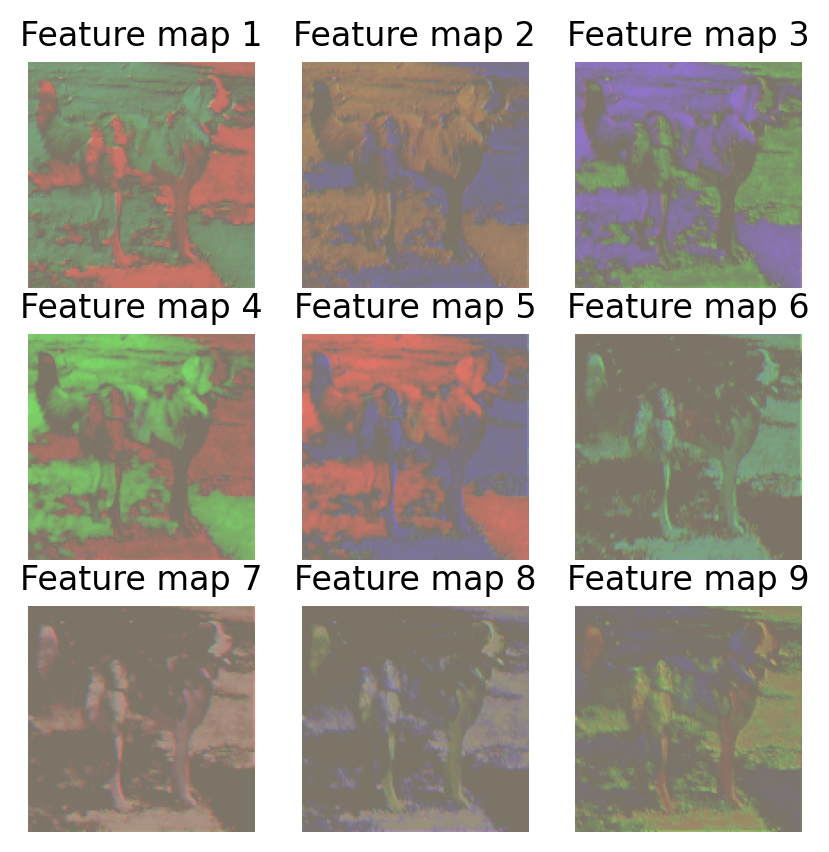

In [32]:
clipped = nn.Sequential(
    *list(model.children())[:1]
)
input = image.to(device)
intermediate_output = clipped(input.unsqueeze(dim=0))
intermediate_output = intermediate_output.squeeze()

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(1, rows * cols + 1):
    img = intermediate_output[i:i+3][:][:]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Feature map {i}")
    plt.axis("off")
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0), cmap="gray")
plt.show()

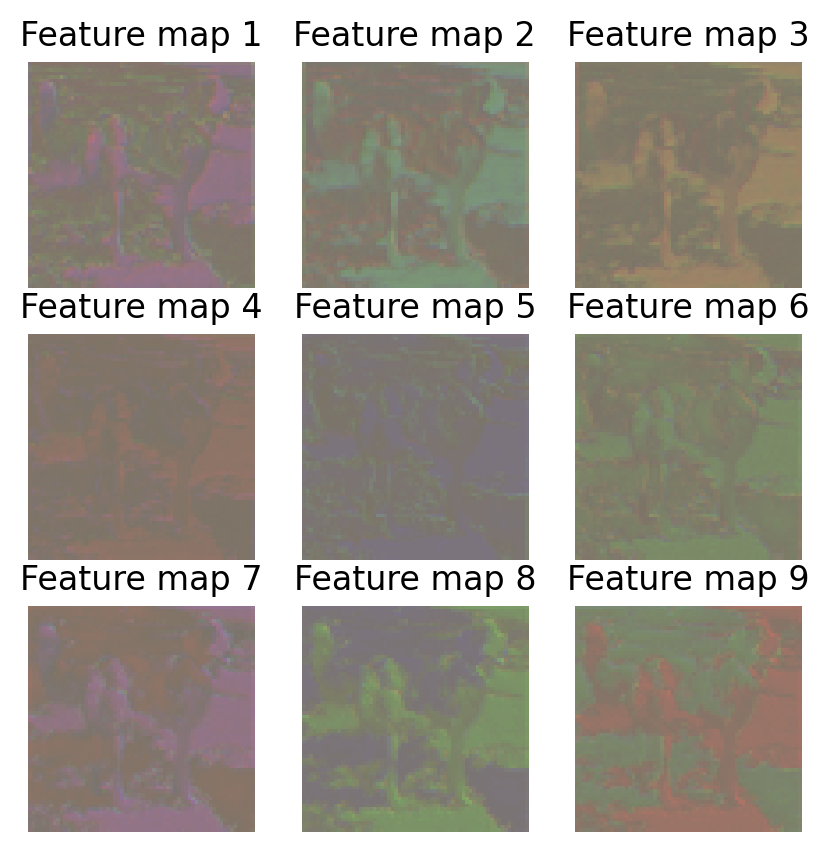

In [33]:
clipped = nn.Sequential(
    *list(model.children())[:2]
)
input = image.to(device)
intermediate_output = clipped(input.unsqueeze(dim=0))
intermediate_output = intermediate_output.squeeze()

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(1, rows * cols + 1):
    img = intermediate_output[i:i+3][:][:]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Feature map {i}")
    plt.axis("off")
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0), cmap="gray")
plt.show()

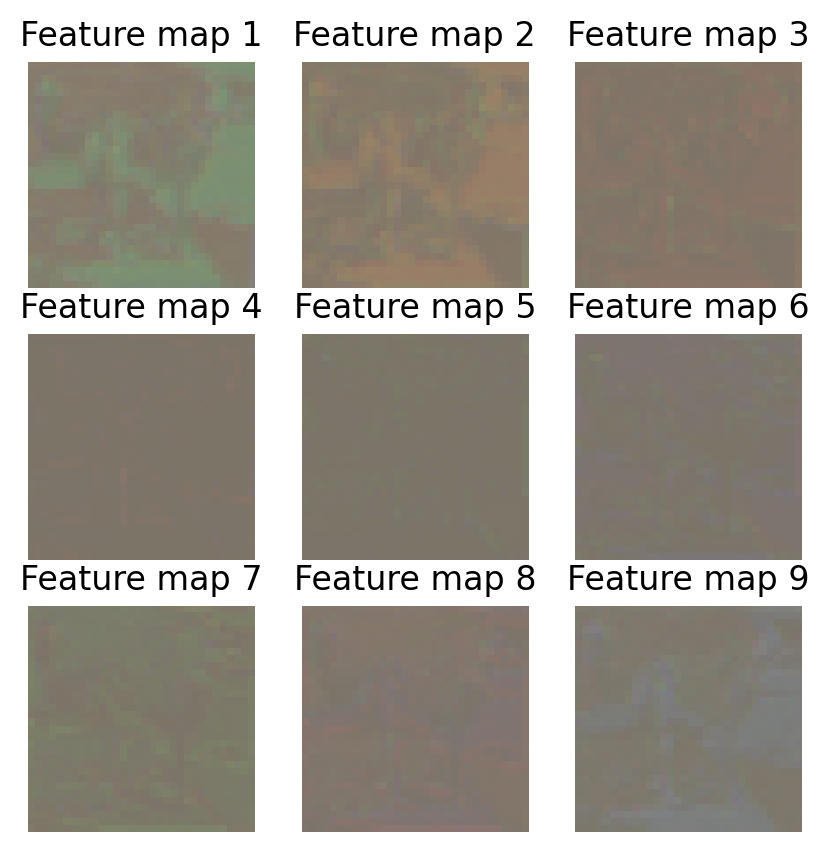

In [34]:
clipped = nn.Sequential(
    *list(model.children())[:3]
)
input = image.to(device)
intermediate_output = clipped(input.unsqueeze(dim=0))
intermediate_output = intermediate_output.squeeze()

figure = plt.figure(figsize=(5, 5))
cols, rows = 3, 3

for i in range(1, rows * cols + 1):
    img = intermediate_output[i:i+3][:][:]
    figure.add_subplot(rows, cols, i)
    plt.title(f"Feature map {i}")
    plt.axis("off")
    plt.imshow(unnormalize(img).detach().cpu().permute(1, 2, 0), cmap="gray")
plt.show()

What can you say about those filters? What features are they focusing on?

Anwer: `Your answer here`